In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ast
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn')

# Загружаем данные

In [2]:
df = pd.read_csv("./Chicago_hotels.csv", sep=';').drop(columns=['x1', 'x3', 'x4'])
X = df.to_numpy()
df.head()

,date1,date2,x2
0,January,1994,104.04
1,February,1994,102.74
2,March,1994,105.23
3,April,1994,113.63
4,May,1994,120.77


# Прогнозирование рядов

Построим графики средней цены номера. 

In [3]:
ex_series = df[df['x2'] != ' ']
ex_series = ex_series.astype({'x2': 'float'})

Text(0, 0.5, 'log10 от $')

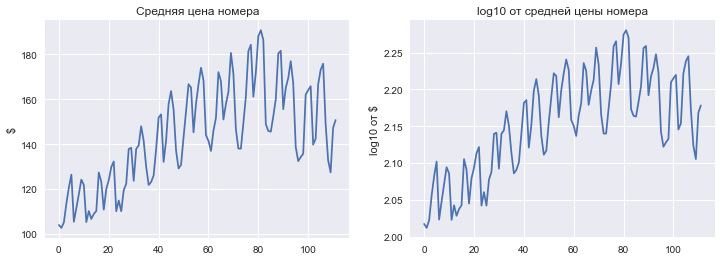

In [4]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ex_series['x2'].plot(ax=ax1)
ax1.set_title(u'Средняя цена номера')
ax1.set_ylabel(u'$')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(ex_series['x2'])).plot(ax=ax2)
ax2.set_title(u'log10 от средней цены номера')
ax2.set_ylabel(u'log10 от $')

На первом графике можем заметить **квадратичный тренд** и **мультипликативную сезонность**, ярких выбросов нет. На втором графике можно заметить, что поправки стали ближе к **аддитивным**. **Вывод:** будем прогнозирвоать логарифм средней цены номера с помощью **модели линейной регрессии**. Также добавим признак квадрата порядкового номера месяца, поскольку видно, что тренд ближе к квадратичной функции.

$$\log y_i = \alpha \cdot x_i^2 + \beta \cdot x_i + c(x_i) + \varepsilon_i,$$
где $y_i$ -- средняя цена номера, $x_i$ -- порядковый номер месяца, $c(x_i)$ -- сезонная составляющая, $\varepsilon_i$ -- случайные отклонения.

Прологарифмируем временной ряд. <br> Создадим предиктор ```month_num``` -- номер наблюдения, то есть номер месяца, считая от первого наблюдения.  Тем самым мы зададим линейный тренд. 

In [5]:
log_y = list(map(lambda x: 0 if x == ' ' else np.log10(ast.literal_eval(x)), df['x2']))

df['month_num'] = range(1, len(df) + 1)
df['month_num_sq'] = np.power(df['month_num'], 2)
df['log_y'] = log_y

df_2 = df.drop(columns=['date1', 'date2', 'x2'])

df_2.head()

,month_num,month_num_sq,log_y
0,1,1,2.017200
1,2,4,2.011740
2,3,9,2.022140
3,4,16,2.055493
4,5,25,2.081959


Создадим новые переменные -- **индикаторы месяцев**.

In [6]:
df_2["m01"] = [1,0,0,0,0,0,0,0,0,0,0,0]*10
df_2["m02"] = [0,1,0,0,0,0,0,0,0,0,0,0]*10
df_2["m03"] = [0,0,1,0,0,0,0,0,0,0,0,0]*10
df_2["m04"] = [0,0,0,1,0,0,0,0,0,0,0,0]*10
df_2["m05"] = [0,0,0,0,1,0,0,0,0,0,0,0]*10
df_2["m06"] = [0,0,0,0,0,1,0,0,0,0,0,0]*10
df_2["m07"] = [0,0,0,0,0,0,1,0,0,0,0,0]*10
df_2["m08"] = [0,0,0,0,0,0,0,1,0,0,0,0]*10
df_2["m09"] = [0,0,0,0,0,0,0,0,1,0,0,0]*10
df_2["m10"] = [0,0,0,0,0,0,0,0,0,1,0,0]*10
df_2["m11"] = [0,0,0,0,0,0,0,0,0,0,1,0]*10
df_2["m12"] = [0,0,0,0,0,0,0,0,0,0,0,1]*10
df_2.head()

,month_num,month_num_sq,log_y,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,1,1,2.017200,1,0,0,0,0,0,0,0,0,0,0,0
1,2,4,2.011740,0,1,0,0,0,0,0,0,0,0,0,0
2,3,9,2.022140,0,0,1,0,0,0,0,0,0,0,0,0
3,4,16,2.055493,0,0,0,1,0,0,0,0,0,0,0,0
4,5,25,2.081959,0,0,0,0,1,0,0,0,0,0,0,0


In [7]:
y = df_2.iloc[:-8]['log_y']
X = df_2.iloc[:-8].drop(columns=['log_y', 'm01']) # m01 -- базовый месяц

Подгоним модель линейной регрессии:

In [8]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

Посмотрим на коэффициенты:

In [9]:
coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,1.964650
1,month_num,0.004532
2,month_num_sq,-0.000027
3,m02,-0.007073
4,m03,0.016714
5,m04,0.043185
6,m05,0.083895
7,m06,0.083492
8,m07,0.021865
9,m08,0.048601


In [10]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef

In [11]:
regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,1.964650,0.000000e+00
1,month_num,0.004532,0.000000e+00
2,month_num_sq,-0.000027,0.000000e+00
3,m02,-0.007073,4.040872e-01
4,m03,0.016714,5.028557e-02
5,m04,0.043185,1.336283e-06
6,m05,0.083895,2.220446e-16
7,m06,0.083492,4.440892e-16
8,m07,0.021865,1.326816e-02
9,m08,0.048601,1.612849e-07


Сравним предсказания с реальными данными:

<AxesSubplot:>

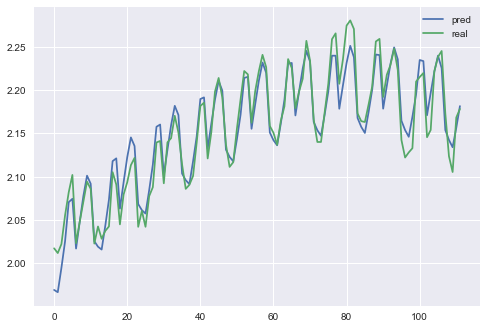

In [12]:
pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

In [13]:
pred.head()

,pred,real
0,1.969155,2.017200
1,1.966533,2.011740
2,1.994719,2.022140
3,2.025535,2.055493
4,2.070537,2.081959


Переходим к прогнозированию:

In [14]:
df_3 = df_2.iloc[-8:].drop(columns=['log_y', 'm01'])
df_3.head()

,month_num,month_num_sq,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
112,113,12769,0,0,0,1,0,0,0,0,0,0,0
113,114,12996,0,0,0,0,1,0,0,0,0,0,0
114,115,13225,0,0,0,0,0,1,0,0,0,0,0
115,116,13456,0,0,0,0,0,0,1,0,0,0,0
116,117,13689,0,0,0,0,0,0,0,1,0,0,0


In [15]:
forecast = model.predict(df_3)
print(f"Прогноз: {10**forecast}")

Прогноз: [166.21771677 165.4866791  143.07734777 151.59651155 160.22301131
 166.91235882 161.22819941 136.56261155]


Построим графики:

Text(0, 0.5, 'log10 от $')

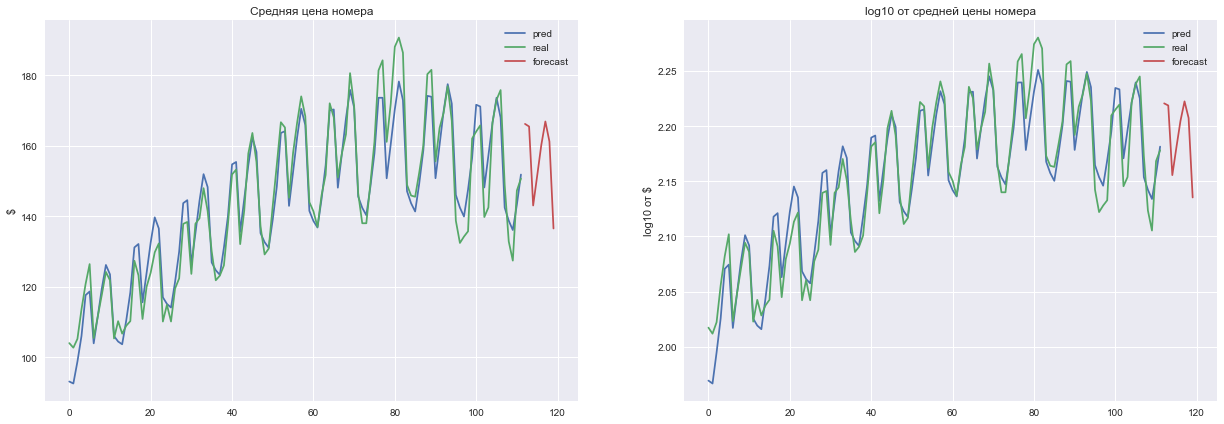

In [16]:
pred['forecast'] = np.nan

pred_2 = pd.DataFrame(forecast, columns=['forecast'])
pred_2['real'] = np.nan
pred_2['pred'] = np.nan

pred_3 = pd.concat(
    [pred, pred_2],
    sort=False
).reset_index(drop=True)

pred_4 = 10**pred_3

fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
pred_4.plot(ax=ax1)
ax1.set_title(u'Средняя цена номера')
ax1.set_ylabel(u'$')

ax2 = fig.add_subplot(122)
pred_3.plot(ax=ax2)
ax2.set_title(u'log10 от средней цены номера')
ax2.set_ylabel(u'log10 от $')